<a href="https://colab.research.google.com/github/fabriciosantana/mcdia/blob/main/01-icd/assignments/04-analise-tematica-discursos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classificação em temas dos Discursos do Senado


## Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import plotly.graph_objects as go
from plotly.colors import qualitative
from datasets import load_dataset
from datasets import load_dataset_builder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)



## Carregar dados

In [2]:
#DATA_PATH = Path('data/hf_discursos/data/full/discursos_2019-02-01_2023-01-31.parquet')
#df_raw = pd.read_parquet(DATA_PATH)

DATASET_HF_REPO = "fabriciosantana/discursos-senado-legislatura-56"
DATA_FILE_HF = {"train": "data/full/discursos_2019-02-01_2023-01-31.parquet"}

dataset = load_dataset(DATASET_HF_REPO, data_files=DATA_FILE_HF)
df_raw = dataset["train"].to_pandas()

df_raw.head()

,id,CodigoPronunciamento,Casa,Data,Resumo,Indexacao,TextoIntegral,TextoIntegralTxt,UrlTextoBinario,TipoAutor,...,Apartes.Aparteante,__janela_inicio,__janela_fim,CargoAutor,OrgaoAutor,PaisAutor,TextoDiscursoIntegral,ok,status,msg
0,451286,451286,Senado Federal,2019-02-27,Comentários a respeito da concentração bancári...,"COMENTARIO, CONCENTRAÇÃO, REDE BANCARIA, COBRA...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,SENADO FEDERAL SF -\nSECRETARIA-GERAL DA MESA\...,True,200,
1,451285,451285,Senado Federal,2019-02-27,Registro do impacto da reforma da previdência ...,"REGISTRO, REFORMA, PREVIDENCIA SOCIAL, ALTERAÇ...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,SENADO FEDERAL SF -\nSECRETARIA-GERAL DA MESA\...,True,200,
2,451205,451205,Senado Federal,2019-02-27,Comentários a respeito da catástrofe ocorrida ...,"COMENTARIO, DESASTRE, ROMPIMENTO, BARRAGEM, BR...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,O SR. WELLINGTON FAGUNDES (Bloco Parlamentar V...,True,200,
3,451203,451203,Senado Federal,2019-02-27,Expectativa com o início dos trabalhos no âmbi...,"EXPECTATIVA, INICIO, TRABALHO, COMISSÕES, SENA...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,O SR. CONFÚCIO MOURA (Bloco Parlamentar Unidos...,True,200,
4,451202,451202,Senado Federal,2019-02-27,Relato da origem e das motivações do Projeto d...,"COMENTARIO, ORIGEM, MOTIVO, PROJETO DE LEI, OB...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,O SR. RODRIGO PACHECO (Bloco Parlamentar Vangu...,True,200,


## Preparar dados para análise temática

Filtramos colunas relevantes, padronizamos o texto e removemos discursos muito curtos para reduzir ruído.


In [3]:
colunas = ['Data', 'NomeAutor', 'Partido', 'UF', 'TextoDiscursoIntegral']

df = (
    df_raw[colunas]
    .rename(columns={
        'TextoDiscursoIntegral': 'texto',
        'NomeAutor': 'nome_autor'
    })
    .dropna(subset=['texto'])
)

# Limpeza básica do texto e metadados
df['texto'] = df['texto'].str.strip()
df = df[df['texto'].str.len() > 0]
df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
df = df.dropna(subset=['Data'])
df['n_palavras'] = df['texto'].str.split().str.len()
df = df[df['n_palavras'] >= 30]
df = df.sort_values('Data').reset_index(drop=True)

print(f"Discursos após limpeza: {len(df):,}")
df.head()


Discursos após limpeza: 14,481


,Data,nome_autor,Partido,UF,texto,n_palavras
0,2019-02-01,Davi Alcolumbre,DEM,AP,O SR. PRESIDENTE (Davi Alcolumbre. DEM - AP) –...,1134
1,2019-02-01,Davi Alcolumbre,DEM,AP,O SR. PRESIDENTE (Davi Alcolumbre. DEM - AP) –...,1077
2,2019-02-01,Davi Alcolumbre,DEM,AP,O SR. PRESIDENTE (Davi Alcolumbre. DEM - AP) –...,925
3,2019-02-01,Major Olimpio,PSL,SP,O SR. MAJOR OLIMPIO (PSL - SP. Pela ordem.) – ...,184
4,2019-02-01,Weverton,PDT,MA,O SR. WEVERTON ROCHA (PDT - MA. Pela ordem.) –...,498


## Selecionar amostra para acelerar modelagem

O conjunto é reduzido para acelerar a vetorização e a extração de temas sem perder representatividade temporal.


In [4]:
MAX_DISCURSOS = 6000

if len(df) > MAX_DISCURSOS:
    df_modelo = df.sample(MAX_DISCURSOS, random_state=42).sort_values('Data').reset_index(drop=True)
else:
    df_modelo = df.copy()

print(f'Tamanho final da amostra: {len(df_modelo):,}')

df_modelo['Data'].agg(['min', 'max'])


Tamanho final da amostra: 6,000


min   2019-02-01
max   2023-01-10
Name: Data, dtype: datetime64[ns]

## Configurar stop words

In [5]:
stopwords_pt = """
a ao aos as ate com como contra da das de dela dele deles delas dentro depois desde dessa desse desta deste disso do dos e ela elas ele eles em entre essa esse essas esses esta este estou eu foi ha isso ja la mais mas mesmo mesma meus minhas na nas nem no nos nossa nosso nossas nossos ou para pela pelas pelo pelos perante pois por porque qual quando que quem se sem ser sob sobre sua suas tambem tem tendo tera teve todos todo um uma umas uns vai ver voce voces
""".split()

stopwords_pt = sorted(set(stopwords_pt))
len(stopwords_pt)


96

## Realizar vetorização com TF-IDF

Transformamos os discursos em vetores de características, preservando unigramas e bigramas frequentes.


In [6]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=15000,
    min_df=20,
    max_df=0.6,
    ngram_range=(1, 2),
    stop_words=stopwords_pt,
    strip_accents='unicode'
)

tfidf_matrix = tfidf_vectorizer.fit_transform(df_modelo['texto'])

print('Dimensões da matriz TF-IDF:', tfidf_matrix.shape)


Dimensões da matriz TF-IDF: (6000, 15000)


## Descobrir temas com NMF

Aplicamos NMF (Non-negative Matrix Factorization) para captar padrões latentes de vocabulário que sugerem temas.


In [7]:
N_TEMAS = 8

nmf_model = NMF(
    n_components=N_TEMAS,
    random_state=42,
    init='nndsvda',
    max_iter=400
)

W = nmf_model.fit_transform(tfidf_matrix)
H = nmf_model.components_

print('Matriz W (documentos x temas):', W.shape)
print('Matriz H (temas x termos):', H.shape)


Matriz W (documentos x temas): (6000, 8)
Matriz H (temas x termos): (8, 15000)


## Analisar principais termos por tema

Listamos as palavras com maior peso em cada tema para auxiliar na interpretação semântica.


In [8]:
def extrair_top_termos(modelo, feature_names, top_n=12):
    registros = []
    for idx, topic in enumerate(modelo.components_):
        top_indices = topic.argsort()[::-1][:top_n]
        termos = [feature_names[i] for i in top_indices]
        registros.append({
            'tema_id': idx,
            'termos': termos,
            'principais_termos': ', '.join(termos[:10])
        })
    return pd.DataFrame(registros)

feature_names = tfidf_vectorizer.get_feature_names_out()
temas_df = extrair_top_termos(nmf_model, feature_names)
temas_df['tema_label'] = temas_df['termos'].apply(lambda termos: ' / '.join(termos[:3]))

# Visualiza termos chave por tema
temas_df[['tema_id', 'tema_label', 'principais_termos']]


,tema_id,tema_label,principais_termos
0,0,gente / governo / pais,"gente, governo, pais, sao, pessoas, temos, ter..."
1,1,bancada / orientar / orientar bancada,"bancada, orientar, orientar bancada, psd, voto..."
2,2,pt / parlamentar resistencia / resistencia dem...,"pt, parlamentar resistencia, resistencia democ..."
3,3,psdb / podemos / psl,"psdb, podemos, psl, psdb psl, podemos psdb, pa..."
4,4,educacao / escola / ensino,"educacao, escola, ensino, escolas, professores..."
5,5,exa / senado / federal,"exa, senado, federal, projeto, art, lei, camar..."
6,6,mulheres / quero / mulher,"mulheres, quero, mulher, meu, dia, grande, min..."
7,7,parlamentar unidos / unidos brasil / unidos,"parlamentar unidos, unidos brasil, unidos, mdb..."


## Atribuir tema predominante aos discursos

Cada discurso recebe o tema com maior peso na decomposição, além da força relativa desse tema.


In [9]:
scores_df = pd.DataFrame(W, columns=[f'tema_{i}' for i in range(N_TEMAS)])

df_temas = df_modelo.reset_index(drop=True).join(scores_df)
df_temas['tema_id'] = scores_df.values.argmax(axis=1)
df_temas = df_temas.merge(temas_df[['tema_id', 'tema_label']], on='tema_id', how='left')

soma_scores = scores_df.sum(axis=1)
df_temas['forca_tema'] = scores_df.max(axis=1) / soma_scores.replace(0, np.nan)

df_temas[['Data', 'nome_autor', 'Partido', 'tema_label', 'forca_tema']].head()


,Data,nome_autor,Partido,tema_label,forca_tema
0,2019-02-01,Eduardo Braga,MDB,exa / senado / federal,0.724819
1,2019-02-01,Angelo Coronel,PSD,exa / senado / federal,0.520319
2,2019-02-01,Eduardo Girão,PROS,gente / governo / pais,0.382259
3,2019-02-01,Juíza Selma,PSL,exa / senado / federal,0.945655
4,2019-02-01,Davi Alcolumbre,DEM,exa / senado / federal,0.453858


## Definir funções auxiliares para visualizações relacionais

Funções utilitárias para preparar fluxos e renderizar gráficos Sankey, reutilizadas nas análises a seguir.


In [10]:
def preparar_fluxo(df, origem, destino, top_origem=None, top_destino=None, min_fluxo=0):
    """Agrupa pares origem-destino e aplica filtros para reduzir ruído."""
    fluxo = (
        df.groupby([origem, destino])
          .size()
          .reset_index(name='n_discursos')
    )

    if top_origem is not None:
        top_vals = (
            fluxo.groupby(origem)['n_discursos']
                 .sum()
                 .nlargest(top_origem)
                 .index
        )
        fluxo = fluxo[fluxo[origem].isin(top_vals)]

    if top_destino is not None:
        top_vals_dest = (
            fluxo.groupby(destino)['n_discursos']
                 .sum()
                 .nlargest(top_destino)
                 .index
        )
        fluxo = fluxo[fluxo[destino].isin(top_vals_dest)]

    if min_fluxo:
        fluxo = fluxo[fluxo['n_discursos'] >= min_fluxo]

    return fluxo.sort_values('n_discursos', ascending=False)


def plotar_sankey(fluxo, origem, destino, valor='n_discursos', titulo=None, altura=600):
    """Plota gráfico Sankey com base no dataframe de fluxos preparado."""
    if fluxo.empty:
        raise ValueError('Fluxo vazio para plotar Sankey.')

    labels = []
    mapa = {}

    for label in fluxo[origem].unique():
        mapa[label] = len(labels)
        labels.append(label)

    for label in fluxo[destino].unique():
        if label not in mapa:
            mapa[label] = len(labels)
            labels.append(label)

    sources = fluxo[origem].map(mapa)
    targets = fluxo[destino].map(mapa)
    values = fluxo[valor]

    palette = qualitative.Plotly
    node_colors = [palette[i % len(palette)] for i in range(len(labels))]

    fig = go.Figure(go.Sankey(
        node=dict(
            pad=16,
            thickness=16,
            line=dict(color='rgba(0,0,0,0.2)', width=0.5),
            label=labels,
            color=node_colors
        ),
        link=dict(source=sources, target=targets, value=values)
    ))

    fig.update_layout(title=titulo, font=dict(size=12), height=altura)
    fig.show()

    return fluxo


## Analisar distribuição geral de temas

Observamos quais temas aparecem com maior frequência na amostra de discursos.


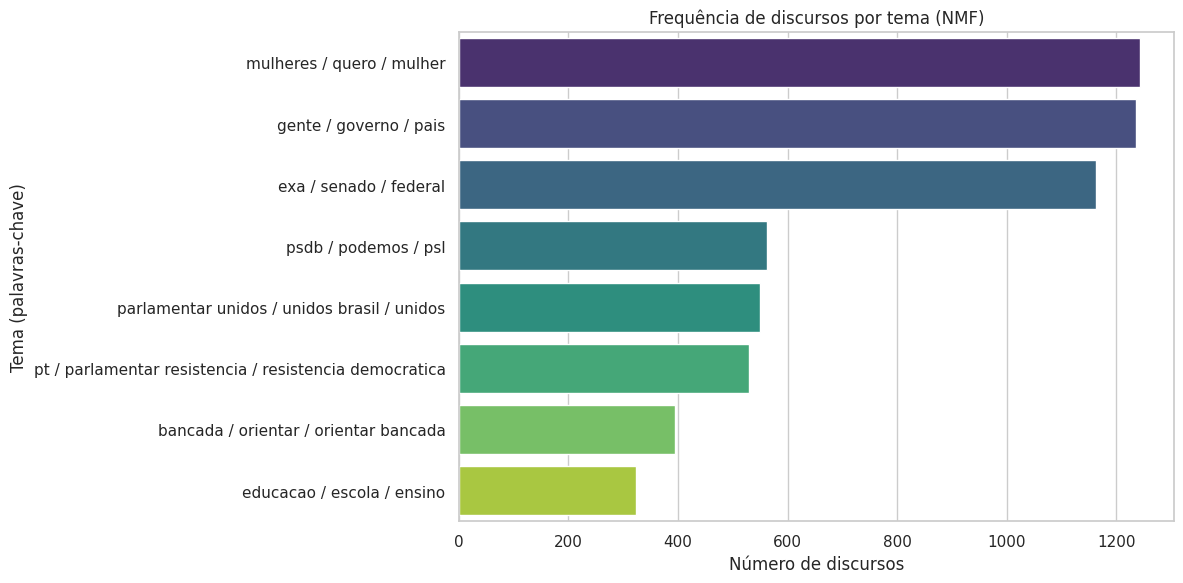

,tema_label,n_discursos
0,mulheres / quero / mulher,1243
1,gente / governo / pais,1235
2,exa / senado / federal,1162
3,psdb / podemos / psl,563
4,parlamentar unidos / unidos brasil / unidos,550
5,pt / parlamentar resistencia / resistencia dem...,530
6,bancada / orientar / orientar bancada,394
7,educacao / escola / ensino,323


In [11]:
contagem_temas = (
    df_temas['tema_label']
        .value_counts()
        .rename_axis('tema_label')
        .reset_index(name='n_discursos')
)

plt.figure(figsize=(12, 6))
sns.barplot(data=contagem_temas, x='n_discursos', y='tema_label', hue='tema_label', palette='viridis', legend=False)
plt.title('Frequência de discursos por tema (NMF)')
plt.xlabel('Número de discursos')
plt.ylabel('Tema (palavras-chave)')
plt.tight_layout()
plt.show()

contagem_temas


## Analisar evolução temporal do interesse por tema

Acompanhamos como a participação relativa de cada tema varia mês a mês.


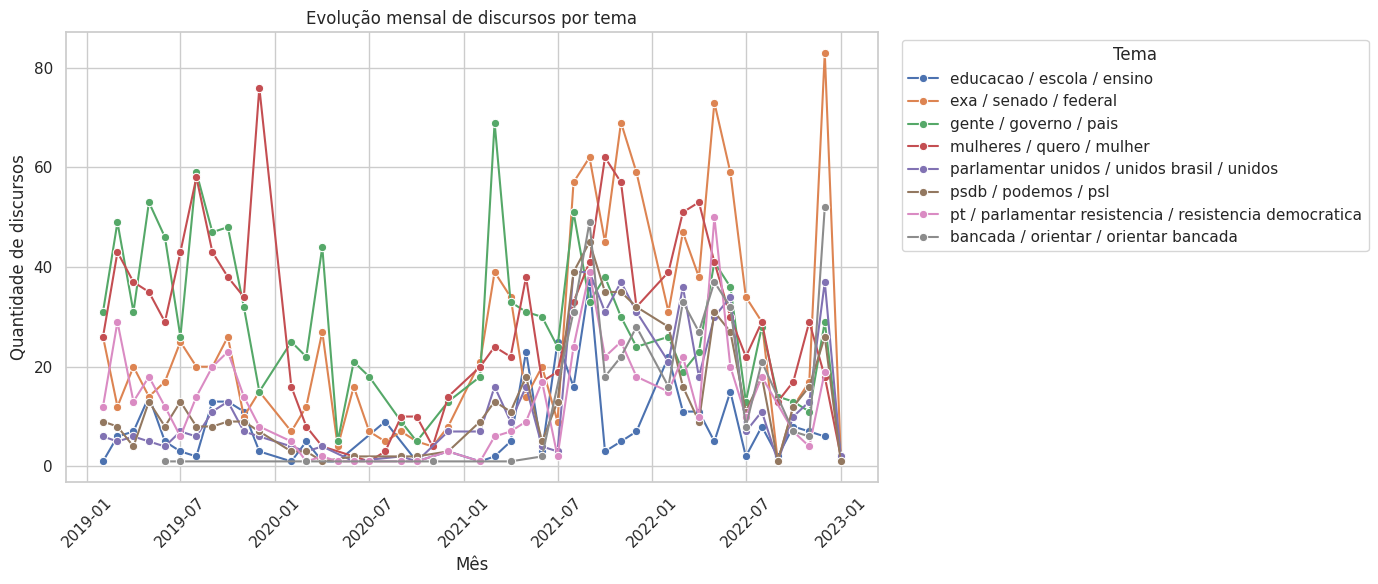

,mes,tema_label,n_discursos
0,2019-02-01,educacao / escola / ensino,1
1,2019-02-01,exa / senado / federal,26
2,2019-02-01,gente / governo / pais,31
3,2019-02-01,mulheres / quero / mulher,26
4,2019-02-01,parlamentar unidos / unidos brasil / unidos,6


In [12]:
df_temas['mes'] = df_temas['Data'].dt.to_period('M').dt.to_timestamp()
serie_temas = (
    df_temas.groupby(['mes', 'tema_label'])
        .size()
        .reset_index(name='n_discursos')
)

plt.figure(figsize=(14, 6))
sns.lineplot(data=serie_temas, x='mes', y='n_discursos', hue='tema_label', marker='o')
plt.title('Evolução mensal de discursos por tema')
plt.xlabel('Mês')
plt.ylabel('Quantidade de discursos')
plt.xticks(rotation=45)
plt.legend(title='Tema', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

serie_temas.head()


## Analisar participação percentual dos temas

Analisamos a participação relativa de cada tema em relação ao total de discursos do mês para identificar mudanças de prioridade ao longo do tempo.


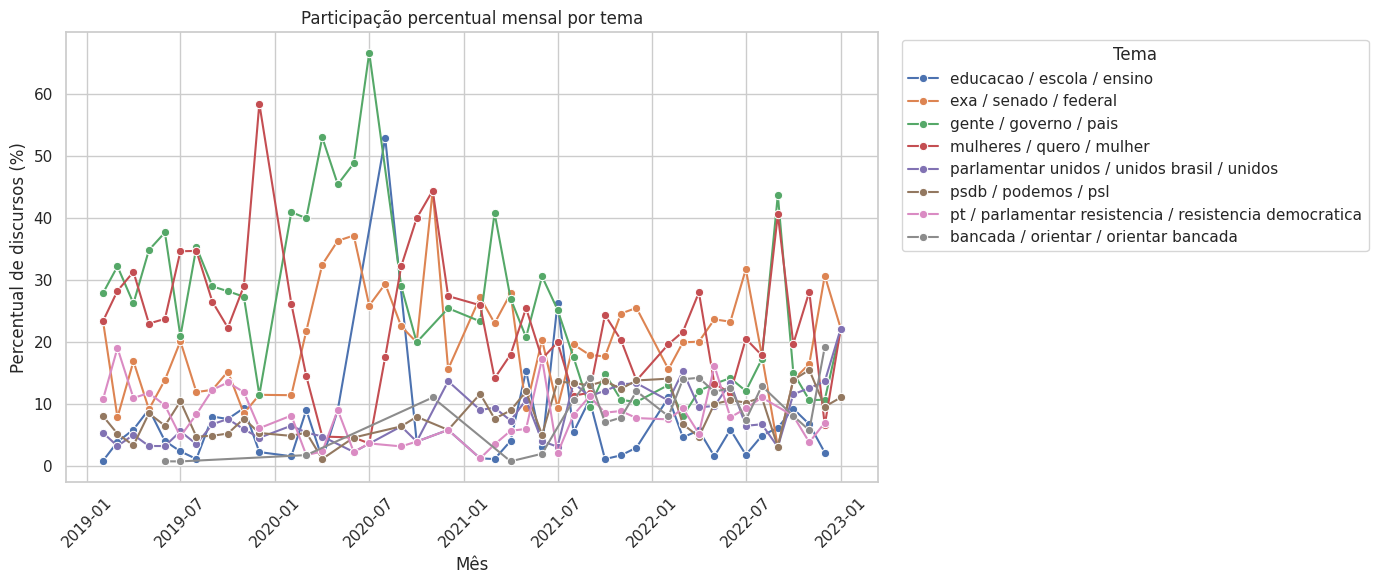

,mes,tema_label,n_discursos,total_mes,percentual
0,2019-02-01,educacao / escola / ensino,1,111,0.900901
1,2019-02-01,exa / senado / federal,26,111,23.423423
2,2019-02-01,gente / governo / pais,31,111,27.927928
3,2019-02-01,mulheres / quero / mulher,26,111,23.423423
4,2019-02-01,parlamentar unidos / unidos brasil / unidos,6,111,5.405405


In [13]:
serie_percentual = (
    serie_temas
        .assign(total_mes=lambda df: df.groupby('mes')['n_discursos'].transform('sum'))
        .assign(percentual=lambda df: (df['n_discursos'] / df['total_mes']) * 100)
)

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=serie_percentual,
    x='mes',
    y='percentual',
    hue='tema_label',
    marker='o'
)
plt.title('Participação percentual mensal por tema')
plt.xlabel('Mês')
plt.ylabel('Percentual de discursos (%)')
plt.xticks(rotation=45)
plt.legend(title='Tema', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

serie_percentual.head()


## Analisar percentual de discursos por tema e por mês

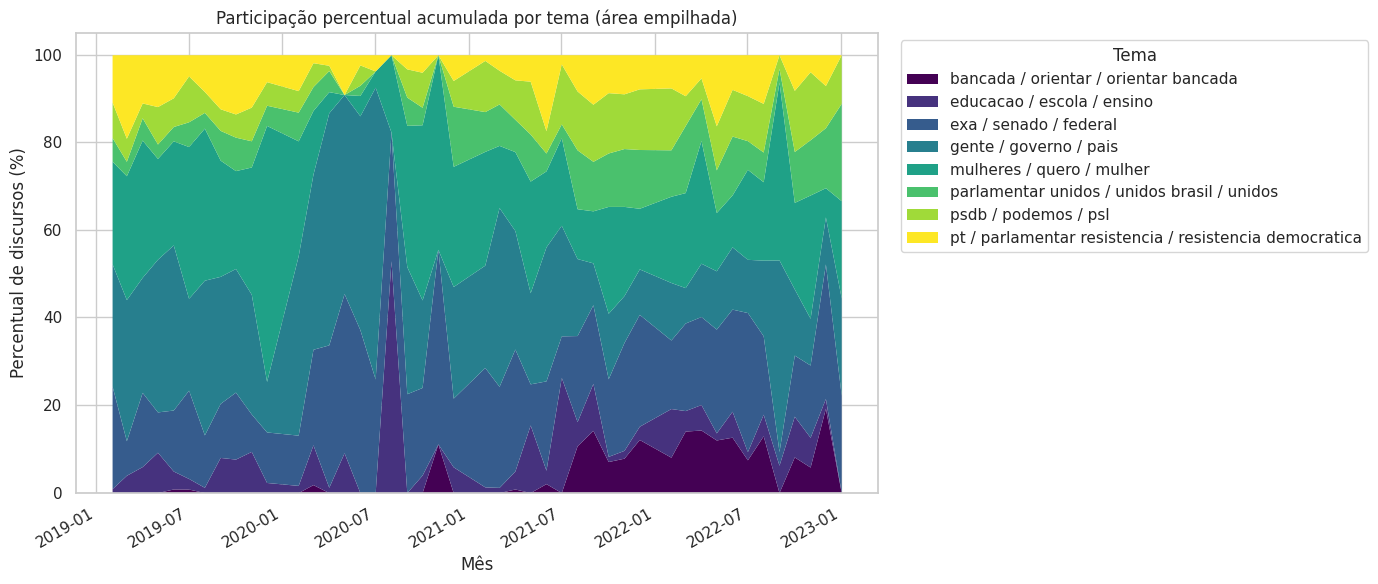

tema_label,bancada / orientar / orientar bancada,educacao / escola / ensino,exa / senado / federal,gente / governo / pais,mulheres / quero / mulher,parlamentar unidos / unidos brasil / unidos,psdb / podemos / psl,pt / parlamentar resistencia / resistencia democratica
mes,,,,,,,,
2022-09-01,0.000000,6.250000,3.125000,43.750000,40.625000,3.125000,3.125000,0.000000
2022-10-01,8.139535,9.302326,13.953488,15.116279,19.767442,11.627907,13.953488,8.139535
2022-11-01,5.825243,6.796117,16.504854,10.679612,28.155340,12.621359,15.533981,3.883495
2022-12-01,19.259259,2.222222,30.740741,10.740741,6.666667,13.703704,9.629630,7.037037
2023-01-01,0.000000,0.000000,22.222222,22.222222,22.222222,22.222222,11.111111,0.000000


In [14]:
serie_area = (
    serie_percentual
        .pivot(index='mes', columns='tema_label', values='percentual')
        .fillna(0)
        .sort_index()
)

ax = serie_area.plot.area(figsize=(14, 6), cmap='viridis', linewidth=0)
ax.set_title('Participação percentual acumulada por tema (área empilhada)')
ax.set_xlabel('Mês')
ax.set_ylabel('Percentual de discursos (%)')
ax.legend(title='Tema', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

serie_area.tail()


## Analisar tema predominante por mês

A tabela abaixo destaca qual tema liderou o volume de discursos em cada mês e a respectiva participação percentual.


In [15]:
tema_lider_mes = (
    serie_percentual
        .sort_values(['mes', 'percentual'], ascending=[True, False])
        .groupby('mes', as_index=False)
        .first()[['mes', 'tema_label', 'percentual']]
)

tema_lider_mes.head(12)


,mes,tema_label,percentual
0,2019-02-01,gente / governo / pais,27.927928
1,2019-03-01,gente / governo / pais,32.236842
2,2019-04-01,mulheres / quero / mulher,31.355932
3,2019-05-01,gente / governo / pais,34.868421
4,2019-06-01,gente / governo / pais,37.704918
5,2019-07-01,mulheres / quero / mulher,34.677419
6,2019-08-01,gente / governo / pais,35.329341
7,2019-09-01,gente / governo / pais,29.012346
8,2019-10-01,gente / governo / pais,28.235294
9,2019-11-01,mulheres / quero / mulher,29.059829


## Analisar conexões entre atores e temas

Exploramos relações entre senadores, partidos, unidades da federação e os temas inferidos para identificar redes de afinidade temática.


### Senadores e temas

Fluxos destacam os senadores mais prolíficos e os temas com os quais mais contribuem.


In [16]:
fluxo_senadores = preparar_fluxo(
    df_temas,
    origem='nome_autor',
    destino='tema_label',
    top_origem=18,
    top_destino=8,
    min_fluxo=15
)

fluxo_senadores_top = plotar_sankey(
    fluxo_senadores,
    origem='nome_autor',
    destino='tema_label',
    titulo='Relação entre senadores e temas predominantes'
)

fluxo_senadores_top.head(10)


,nome_autor,tema_label,n_discursos
1136,Rodrigo Pacheco,exa / senado / federal,186
538,Izalci Lucas,psdb / podemos / psl,185
359,Esperidião Amin,parlamentar unidos / unidos brasil / unidos,151
1012,Paulo Paim,pt / parlamentar resistencia / resistencia dem...,149
606,Jean-Paul Prates,pt / parlamentar resistencia / resistencia dem...,105
1017,Paulo Rocha,pt / parlamentar resistencia / resistencia dem...,91
181,Carlos Portinho,bancada / orientar / orientar bancada,85
326,Eduardo Girão,psdb / podemos / psl,83
1323,Zenaide Maia,gente / governo / pais,82
1100,Randolfe Rodrigues,exa / senado / federal,80


### Partidos e temas

Mostra como cada legenda concentra seu discurso em determinados assuntos.


In [17]:
fluxo_partidos = preparar_fluxo(
    df_temas,
    origem='Partido',
    destino='tema_label',
    top_origem=12,
    top_destino=8,
    min_fluxo=25
)

fluxo_partidos_top = plotar_sankey(
    fluxo_partidos,
    origem='Partido',
    destino='tema_label',
    titulo='Relação entre partidos e temas predominantes'
)

fluxo_partidos_top.head(10)


,Partido,tema_label,n_discursos
130,PT,pt / parlamentar resistencia / resistencia dem...,409
23,MDB,parlamentar unidos / unidos brasil / unidos,294
61,PODEMOS,psdb / podemos / psl,256
110,PSDB,psdb / podemos / psl,242
98,PSD,exa / senado / federal,225
68,PP,parlamentar unidos / unidos brasil / unidos,223
13,DEM,exa / senado / federal,153
58,PODEMOS,gente / governo / pais,143
43,PL,bancada / orientar / orientar bancada,116
78,PROS,gente / governo / pais,115


### Unidades da federação e temas

A análise revela quais temas dominam a pauta dos senadores de cada estado.


In [18]:
fluxo_uf = preparar_fluxo(
    df_temas,
    origem='UF',
    destino='tema_label',
    top_origem=12,
    top_destino=8,
    min_fluxo=20
)

fluxo_uf_top = plotar_sankey(
    fluxo_uf,
    origem='UF',
    destino='tema_label',
    titulo='Relação entre unidades da federação e temas'
)

fluxo_uf_top.head(10)


,UF,tema_label,n_discursos
78,MG,exa / senado / federal,237
51,DF,psdb / podemos / psl,194
176,SC,parlamentar unidos / unidos brasil / unidos,164
170,RS,pt / parlamentar resistencia / resistencia dem...,151
147,RN,pt / parlamentar resistencia / resistencia dem...,146
143,RN,gente / governo / pais,115
96,MT,mulheres / quero / mulher,112
43,CE,psdb / podemos / psl,88
49,DF,mulheres / quero / mulher,87
71,MA,exa / senado / federal,86


### Matriz de intensidade partido × tema

A matriz complementar permite comparar a distribuição percentual dos discursos entre partidos e temas.


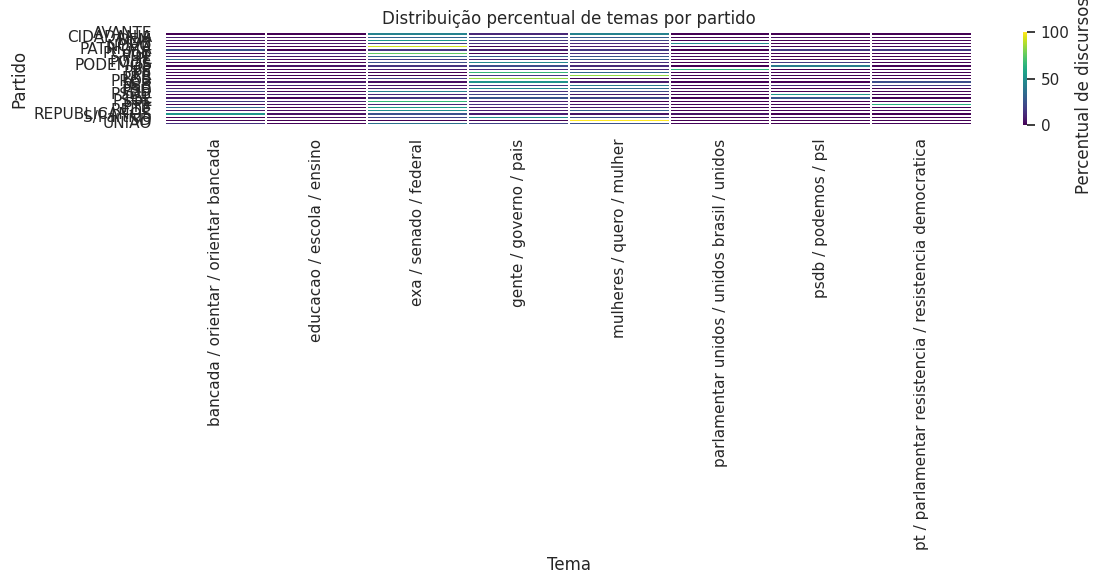

tema_label,bancada / orientar / orientar bancada,educacao / escola / ensino,exa / senado / federal,gente / governo / pais,mulheres / quero / mulher,parlamentar unidos / unidos brasil / unidos,psdb / podemos / psl,pt / parlamentar resistencia / resistencia democratica
Partido,,,,,,,,
AVANTE,0.0,0.0,44.4,11.1,44.4,0.0,0.0,0.0
CIDADANIA,7.0,3.8,31.9,21.1,29.1,0.9,4.2,1.9
DEM,5.0,2.8,54.4,16.0,19.9,0.7,0.0,1.1
MDB,4.3,5.7,16.9,13.1,11.9,46.5,0.3,1.3
NOVO,0.0,0.0,93.3,0.0,6.7,0.0,0.0,0.0


In [19]:
matriz_partido_tema = (
    df_temas.groupby(['Partido', 'tema_label'])
        .size()
        .unstack(fill_value=0)
)

matriz_partido_tema_pct = matriz_partido_tema.div(matriz_partido_tema.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 6))
sns.heatmap(matriz_partido_tema_pct, cmap='viridis', linewidths=0.1, cbar_kws={'label': 'Percentual de discursos (%)'})
plt.title('Distribuição percentual de temas por partido')
plt.xlabel('Tema')
plt.ylabel('Partido')
plt.tight_layout()
plt.show()

matriz_partido_tema_pct.round(1).head()
